## 测试IHN代码(CVUSA-20)
- 修改tgm.get_perspective_transform()源码 
- X, LU = torch.gesv(b, A)   ===>   X = torch.linalg.solve(A, b)

- 设置参数

In [1]:
from sklearn.decomposition import PCA
def get_feature_show(feature_map):
    # 加载特征图, inputs.shape = [batch, channel,H,W]
    feature_map = feature_map.squeeze(0).permute(1,2,0)
    feature_map = feature_map.cpu().detach().numpy()

    # 将特征图展平为一维数组
    feature_vector = feature_map.reshape(-1, feature_map.shape[-1])

    # 创建PCA对象，并设置降维后的维度
    pca = PCA(n_components=3)

    # 对特征向量进行降维
    feature_reduced = pca.fit_transform(feature_vector)

    # 将降维后的特征向量重新形状为特征图的形状
    feature_reduced = feature_reduced.reshape(feature_map.shape[:-1] + (3,))

    # 将像素值限制在0到1之间
    feature_reduced = np.clip(feature_reduced, 0, 1)
    return feature_reduced

In [2]:
import numpy as np
import os
import torch
import argparse
from network import IHN
from utils import *
import datasets_4cor_img as datasets
import scipy.io as io
import torchvision
import numpy as np
import time
setup_seed(2022)

parser = argparse.ArgumentParser()
parser.add_argument('--model', default='results/moveobj_lev1/IHN.pth',help="restore checkpoint")
parser.add_argument('--iters_lev0', type=int, default=6)
parser.add_argument('--iters_lev1', type=int, default=6)
parser.add_argument('--mixed_precision', default=False, action='store_true',
                    help='use mixed precision')
parser.add_argument('--dropout', type=float, default=0.0)
parser.add_argument('--gpuid', type=int, nargs='+', default=[0])
parser.add_argument('--savemat', type=str,  default='mscoco.mat')
parser.add_argument('--savedict', type=str, default='mscoco.npy')
parser.add_argument('--dataset', type=str, default='mscoco', help='dataset')    
parser.add_argument('--lev0', default=True, action='store_true',
                    help='warp no')
parser.add_argument('--lev1', default=False, action='store_true',
                    help='warp once')
parser.add_argument('--weight', default=False, action='store_true',
                    help='weight')
parser.add_argument('--model_name_lev0', default='', help='specify model0 name')
parser.add_argument('--model_name_lev1', default='', help='specify model0 name')

args = parser.parse_args([]) # '--model', 'results/moveobj/IHN.pth'

- 读入模型与数据

In [3]:
device = torch.device('cuda:'+ str(args.gpuid[0]))

model = IHN(args)
model_med = torch.load(args.model, map_location='cuda:0')
model.load_state_dict(model_med,strict = False)

model.to(device) 
model.eval()

batchsz = 1

In [4]:
def compute_params(model):
    # 定义总参数量、可训练参数量及非可训练参数量变量
    Total_params = 0
    Trainable_params = 0
    NonTrainable_params = 0

    # 遍历model.parameters()返回的全局参数列表
    for param in model.parameters():
        mulValue = np.prod(param.size())  # 使用numpy prod接口计算参数数组所有元素之积
        Total_params += mulValue  # 总参数量
        if param.requires_grad:
            Trainable_params += mulValue  # 可训练参数量
        else:
            NonTrainable_params += mulValue  # 非可训练参数量

    print(f'Total params: {Total_params}')
    print(f'Trainable params: {Trainable_params}')
    print(f'Non-trainable params: {NonTrainable_params}')
compute_params(model)

Total params: 1307970
Trainable params: 1307970
Non-trainable params: 0


- 读入卫星图数据

In [5]:
# 读入卫星图数据
import cv2
import matplotlib.pyplot as plt
vigor_root = "/home/wxl/Data/VIGOR/"
label_root = 'splits'
city = 'Seattle'
pano_list = []
pano_label = []
sat_list = []
sat_delta = []
sat_index_dict = {}
label_fname = os.path.join(vigor_root, label_root, city, 'pano_label_balanced.txt')
with open(label_fname, 'r') as file:
        for line in file.readlines():
            data = np.array(line.split(' '))
            label = []
            for i in [1, 4, 7, 10]:
                label.append(data[i])
            # label = np.array(label).astype(np.int)
            delta = np.array([data[2:4], data[5:7], data[8:10], data[11:13]]).astype(float)
            pano_list.append(os.path.join(vigor_root, city, 'panorama', data[0]))
            pano_label.append(label)
            sat_delta.append(delta)

In [6]:
idx = 5#737

Read image ues 0.00 ms, warpPerspective image use 7.95 ms, Get matrix ues 1158.90 ms, Get out ues 143.31 ms, All out ues 1310.17 ms.


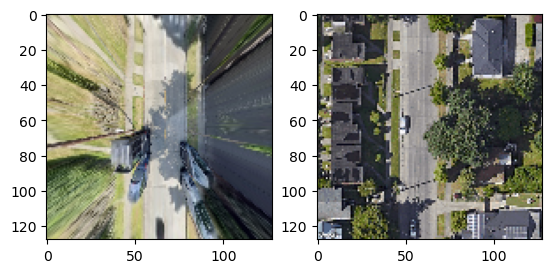

In [7]:
# matplotlib.use('TkAgg')
%matplotlib inline
ImgPath = pano_list[idx]
img2 = cv2.imread(os.path.join(vigor_root, city, 'satellite', pano_label[idx][0]),1)[:,:,::-1]
img1 = cv2.imread(pano_list[idx], 1)[:,:,::-1]
img1 = get_BEV_tensor(img1,500,500,dty = 0, dy = 0).numpy().astype(np.uint8)
# img1 = img1[250:, 250:]
h2,w2,_ = img2.shape
# tl_y, tl_x, br_y,br_x = np.array([h2/2-250,w2/2-200,h2/2+250,w2/2+150]).astype(np.uint16)
tl_y, tl_x, br_y,br_x = 0,0,h2,w2
corners0 = np.array([[tl_x, tl_y], [tl_x, br_y], [br_x, tl_y], [br_x, br_y]], dtype=np.float32)
img2_ = img2[tl_y:br_y, tl_x:br_x]
h1,w1,_ = img1.shape
h2,w2,_ = img2.shape
corners1 = np.array([[0, 0], [0, h1], [w1, 0], [w1, h1]], dtype=np.float32)
corners2 = np.array([[0, 0], [0, h2], [w2, 0], [w2, h2]], dtype=np.float32)
corners_128 = np.array([[0, 0], [0, 128], [128, 0], [128, 128]], dtype=np.float32)
H0 = cv2.getPerspectiveTransform(corners0, corners2)
H1 = cv2.getPerspectiveTransform(corners1, corners_128)
H2 = cv2.getPerspectiveTransform(corners2, corners_128)
img1_ = cv2.resize(img1, (128, 128))
img2_ = cv2.resize(img2_, (128, 128))
plt.subplot(1,2,1)
plt.imshow(img1_)
plt.subplot(1,2,2)
plt.imshow(img2_)
img1_ = torch.from_numpy((img1_)).float().permute(2, 0, 1).unsqueeze(0)
img2_ = torch.from_numpy((img2_)).float().permute(2, 0, 1).unsqueeze(0)

- 网络模型预测

In [10]:
# 网络模型预测
import time
img1_ = img1_.to(model.device)
img2_ = img2_.to(model.device)
start = time.time()
four_pred, fmap1,fmap2 = model(img1_, img2_, iters_lev0=args.iters_lev0, iters_lev1=args.iters_lev1, test_mode=True)
print(1000*(time.time() - start))

# flow_4cor = torch.zeros((four_pred.shape[0], 2, 2, 2))
# flow_4cor[:, :, 0, 0] = flow_gt[:, :, 0, 0]
# flow_4cor[:, :, 0, 1] = flow_gt[:, :, 0, -1]
# flow_4cor[:, :, 1, 0] = flow_gt[:, :, -1, 0]
# flow_4cor[:, :, 1, 1] = flow_gt[:, :, -1, -1]
# mace_ = (flow_4cor - four_pred.cpu().detach())**2
# mace_ = ((mace_[:,0,:,:] + mace_[:,1,:,:])**0.5)
# mace_vec = torch.mean(torch.mean(mace_, dim=1), dim=1)
# four_pred.shape,four_pred, flow_4cor,mace_, mace_.shape, mace_vec

23.256540298461914


(torch.Size([1, 256, 32, 32]), torch.Size([1, 256, 32, 32]))

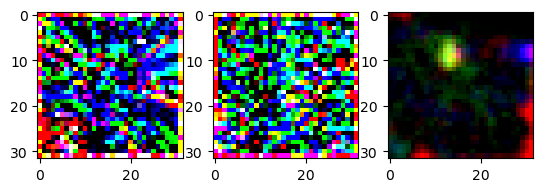

In [15]:
plt.subplot(1,3,1)
plt.imshow(get_feature_show(fmap1))
plt.subplot(1,3,2)
plt.imshow(get_feature_show(fmap2))
plt.subplot(1,3,3)
plt.imshow(get_feature_show(loss))
fmap1.shape,fmap1.shape

- 计算单应矩阵

In [13]:
# 计算单应矩阵
import torchgeometry as tgm
four_point_org = torch.zeros((2, 2, 2)).to(four_pred.device)
four_point_org[:, 0, 0] = torch.Tensor([0, 0])
four_point_org[:, 0, 1] = torch.Tensor([127, 0])
four_point_org[:, 1, 0] = torch.Tensor([0, 127])
four_point_org[:, 1, 1] = torch.Tensor([127, 127])
four_point_new = four_point_org + four_pred.squeeze(0)
H = tgm.get_perspective_transform(four_point_org.unsqueeze(0).flatten(2).permute(0,2,1), four_point_new.unsqueeze(0).flatten(2).permute(0,2,1))
H = H[0].detach().cpu().numpy()
H_ = np.linalg.inv(H0).dot(np.linalg.inv(H2)).dot(H).dot(H1)

In [14]:
from loss_factory import *
H = get_homograpy(four_pred,fmap1.shape,k=4)
temp = tgm.warp_perspective(fmap2, torch.inverse(H), fmap1.shape[-2:])
ssim = tgm.losses.SSIM(5, reduction='none')
loss = ssim(temp, fmap1)
# loss = SSIM(fmap2, fmap1, mean=False)
mask = (temp>0)#[:,:,1:-1,1:-1]
torch.sum(mask*loss)/torch.sum(mask)#, ((1-loss[0,2,:,:])==0).sum(),3*128*128, (temp==0).sum(), loss[0,0,120,50]

/home/wxl/anaconda3/envs/torch/lib/python3.8/site-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


tensor(0.4928, device='cuda:0', grad_fn=<DivBackward0>)

In [17]:
from loss_factory import *
H = get_homograpy(four_pred,img1_.shape,k=4)
temp = tgm.warp_perspective(img2_, torch.inverse(H), img1_.shape[-2:])
ssim = tgm.losses.SSIM(5, reduction='none')
loss = ssim(temp, img1_)
# loss = SSIM(temp, fmap1)
mask = (temp>0)#[:,:,1:-1,1:-1]
torch.sum(mask*loss)/torch.sum(mask)#, ((1-loss[0,2,:,:])==0).sum(),3*128*128, (temp==0).sum(), loss[0,0,120,50]

/home/wxl/anaconda3/envs/torch/lib/python3.8/site-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


tensor(0.4868, device='cuda:0', grad_fn=<DivBackward0>)

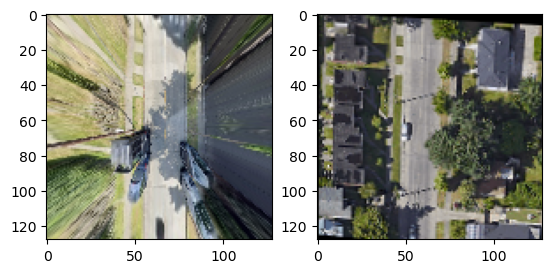

In [18]:
plt.subplot(1,2,1)
plt.imshow(img1_[0].permute(1,2,0).detach().cpu()/255)
plt.subplot(1,2,2)
plt.imshow(temp[0].permute(1,2,0).detach().cpu()/255)

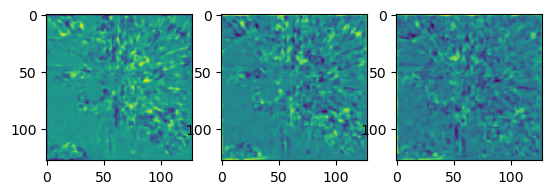

In [15]:
loss.shape
plt.subplot(1,3,1)
plt.imshow(loss[0,0,:,:].detach().cpu())
plt.subplot(1,3,2)
plt.imshow(1-loss[0,1,:,:].detach().cpu())
plt.subplot(1,3,3)
plt.imshow(1-loss[0,2,:,:].detach().cpu())

- 显示输出

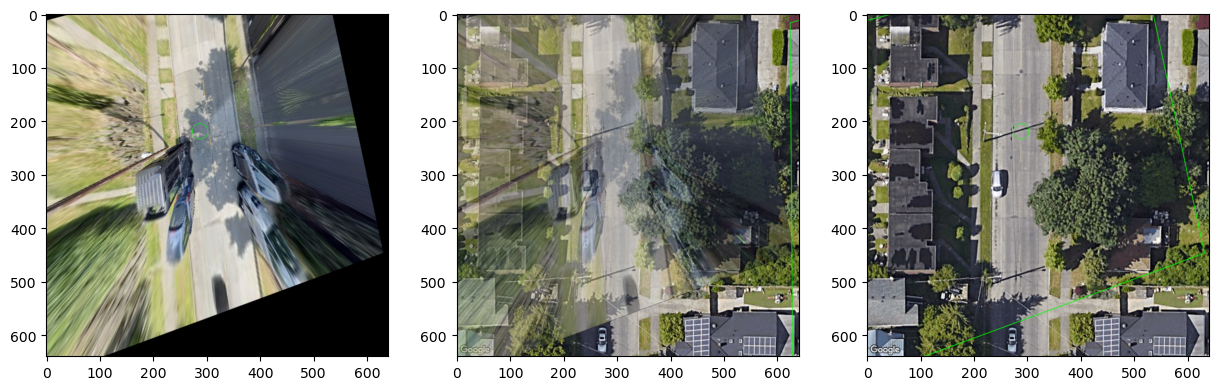

In [20]:
plt.figure(figsize=(15,5))
# plt.tight_layout()
result = show_overlap(img1, img2, H_)
# result = show_overlap(img2, img1, np.linalg.inv(H_))
# plt.figure(figsize=(20,5))
# plt.imshow(result/255)W

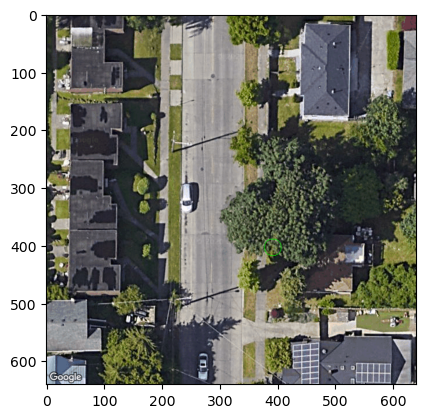

In [21]:
img2 = cv2.circle(np.ascontiguousarray(img2),(int(392),int(403)),15,(0,255,0),1)
plt.imshow(img2)

In [22]:
# compute the distance between two locations [Lat_A,Lng_A], [Lat_B,Lng_B]
import math
def gps2distance(Lat_A,Lng_A,Lat_B,Lng_B):
    # https://en.wikipedia.org/wiki/Great-circle_distance
    lat_A = math.radians(Lat_A)
    lat_B = math.radians(Lat_B)
    lng_A = math.radians(Lng_A)
    lng_B = math.radians(Lng_B)
    R = 6371004.
    C = math.sin(lat_A)*math.sin(lat_B) + math.cos(lat_A)*math.cos(lat_B)*math.cos(lng_A-lng_B)
    distance = R*math.acos(C)
    return distance
def distance(lat1, lon1, lat2, lon2):
  # 将经纬度转换为弧度
  lat1 = math.radians(lat1)
  lon1 = math.radians(lon1)
  lat2 = math.radians(lat2)
  lon2 = math.radians(lon2)

  # 计算两点之间的球面中心角
  dlon = lon2 - lon1
  dlat = lat2 - lat1
  a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
  c = 2 * math.asin(math.sqrt(a))

  # 假设地球是一个标准球体，其半径为6371000米
  r = 6371004

  # 计算并返回两点之间的距离
  return c * r

In [24]:
from image_generation import *
h_,w_ = img1.shape[0],img1.shape[1]
center = np.float32( [w_/2, h_/2]).reshape(-1, 1, 2)
dst_center = cv2.perspectiveTransform(center, H_).reshape(-1, 2)
lat = float(ImgPath.split('/')[-1].split(',')[-3])
lon = float(ImgPath.split('/')[-1].split(',')[-2])

zoom = 20
Lat_A, Lng_A = get_loc_lonlat(lat, lon, 0, 0, zoom)
Lat_B,Lng_B = get_loc_lonlat(lat, lon, 1, 0, zoom)
dv = distance(Lat_A,Lng_A,Lat_B,Lng_B)

Lat_B,Lng_B = get_loc_lonlat(lat, lon, 0, 1, zoom)
du = distance(Lat_A,Lng_A,Lat_B,Lng_B)

u,v = dst_center[0][0],dst_center[0][1]

delta_v = v-320
delta_u = 320-u 
delta = np.array([delta_v, delta_u])
print("errer : {:.4f} m".format(math.dist(delta,sat_delta[idx][0])*dv))

delta_v,delta_u,sat_delta[idx][0], np.array([(delta_v-sat_delta[idx][0][0])*dv,(delta_u-sat_delta[idx][0][1])*du])

errer : 1.5451 m


(-100.6092529296875,
 31.210418701171875,
 array([-88.,  40.]),
 array([-1.26752397, -0.88355792]))

In [145]:
center = np.array([250,250,1])
end = np.matmul(H_, center)
end = end/end[2]
end, u,v

(array([400.54004261, 419.54158457,   1.        ]), 400.54004, 419.5416)

In [11]:
t0 = time.time()
fmap1 = torch.rand(1,256,64*64).to(device)
fmap2 = torch.rand(1,256,64*64).to(device)
corr = torch.relu(torch.matmul(fmap1.transpose(1, 2), fmap2))
(time.time() - t0)*1000

9.129524230957031